In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)


In [3]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]



In [4]:
print(test.shape)

(22544, 42)


In [5]:
# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes


In [6]:
# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)


In [7]:
# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training data: {x_train.shape}, Validation data: {x_val.shape}, Test data: {X_test.shape}")


Training data: (100778, 41), Validation data: (25195, 41), Test data: (22544, 41)


In [9]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by number of heads.")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        return tf.matmul(weights, value), weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)


In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [11]:
embed_dim = 32  # Embedding size
num_heads = 4  # Number of attention heads
ff_dim = 64  # Feedforward network dimension

inputs = layers.Input(shape=(x_train.shape[1],))
x = layers.Dense(embed_dim)(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense (Dense)               (None, 32)                1344      
                                                                 
 transformer_block (Transfor  (None, None, 32)         8544      
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056  

In [12]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50, batch_size=32
)


Epoch 1/50
3150/3150 [==============================] - 35s 10ms/step - loss: 0.0598 - accuracy: 0.9772 - val_loss: 0.0319 - val_accuracy: 0.9862
Epoch 2/50
3150/3150 [==============================] - 32s 10ms/step - loss: 0.0371 - accuracy: 0.9858 - val_loss: 0.0296 - val_accuracy: 0.9890
Epoch 3/50
3150/3150 [==============================] - 31s 10ms/step - loss: 0.0328 - accuracy: 0.9871 - val_loss: 0.0350 - val_accuracy: 0.9859
Epoch 4/50
3150/3150 [==============================] - 32s 10ms/step - loss: 0.0314 - accuracy: 0.9877 - val_loss: 0.0248 - val_accuracy: 0.9902
Epoch 5/50
3150/3150 [==============================] - 33s 10ms/step - loss: 0.0297 - accuracy: 0.9883 - val_loss: 0.0234 - val_accuracy: 0.9914
Epoch 6/50
3150/3150 [==============================] - 33s 10ms/step - loss: 0.0290 - accuracy: 0.9886 - val_loss: 0.0270 - val_accuracy: 0.9890
Epoch 7/50
3150/3150 [==============================] - 33s 10ms/step - loss: 0.0282 - accuracy: 0.9893 - val_loss: 0.0226 -

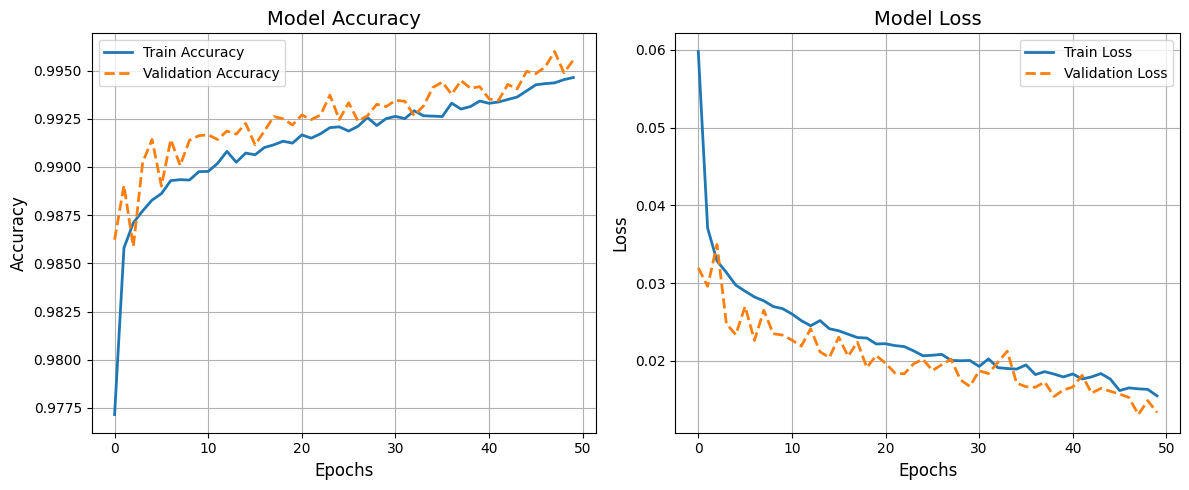

In [13]:
import matplotlib.pyplot as plt

# Training History
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", linewidth=2)
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="--", linewidth=2)
plt.title("Model Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("visualization/MultiHead_training_accuracy.png")
plt.close()






In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


705/705 [==============================] - 4s 5ms/step - loss: 1.1805 - accuracy: 0.7879
Test Loss: 1.1804953813552856, Test Accuracy: 0.7879258394241333


In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1804953813552856
Test accuracy: 0.7879258394241333


In [16]:
score = model.evaluate(x_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.013363067992031574
Test accuracy: 0.9955546855926514


In [17]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

705/705 [==============================] - 4s 5ms/step


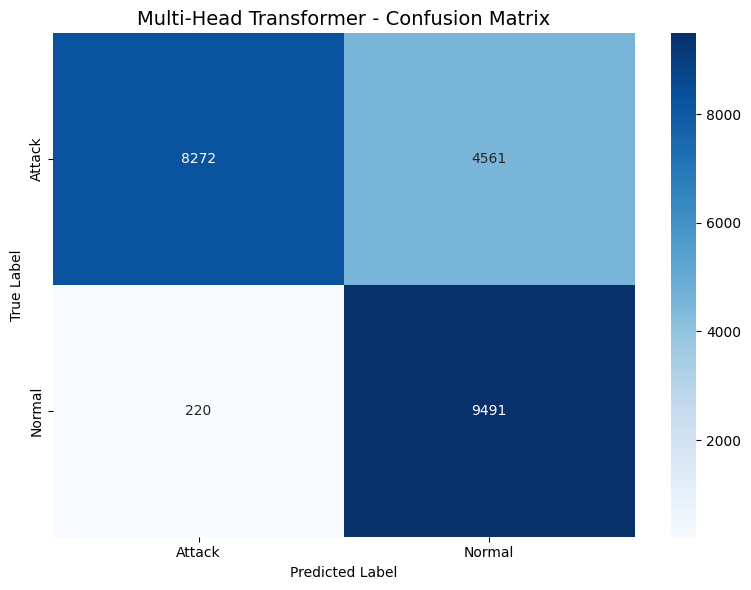

              precision    recall  f1-score   support

      Attack       0.97      0.64      0.78     12833
      Normal       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544



In [20]:
# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Multi-Head Transformer - Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("visualization/confusion_matrix.png")
plt.show()
plt.close()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

705/705 [==============================] - 3s 4ms/step


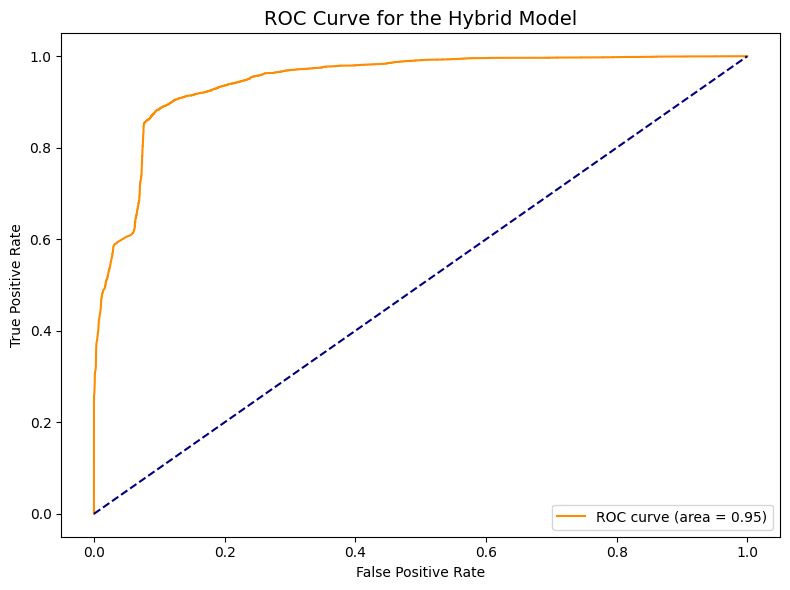

In [21]:
# ROC Curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("visualization/roc_curve.png")
plt.show()
plt.close()
